In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import random
import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
latent_dims = 128

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './data',
        train=True,
        transform=torchvision.transforms.ToTensor(),
        download=True),
    batch_size=64,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './data',
        train=False,
        transform=torchvision.transforms.ToTensor(),
        download=True),
    batch_size=64,
    shuffle=False
)

In [131]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU()
        )

        self.linear1 = nn.Linear(64*22*22, latent_dims)
        self.linear2 = nn.Linear(64*22*22, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(self.conv(x), start_dim=1)
        mu =  self.linear1(x)
        sigma = torch.exp(self.linear2(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [130]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()

        self.linear = nn.Linear(latent_dims, 64*22*22)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3)
        )

    def forward(self, z):
        z = self.linear(z)
        z = z.view(-1, 64, 22, 22)
        return torch.sigmoid(self.deconv(z))

In [132]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [133]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm.tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [151]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, train_loader, epochs=15)

100%|██████████| 15/15 [03:54<00:00, 15.63s/it]


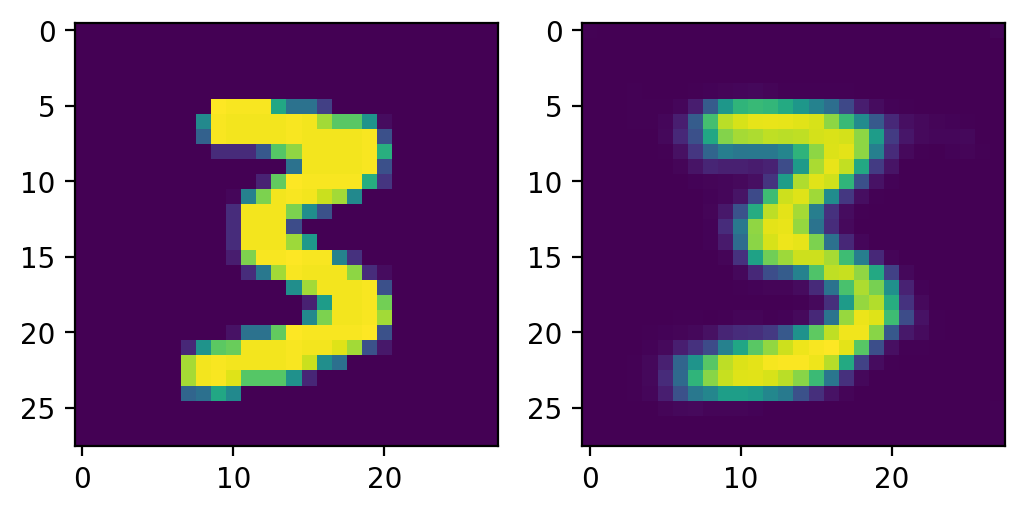

In [155]:
vae.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out = vae(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break

In [153]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

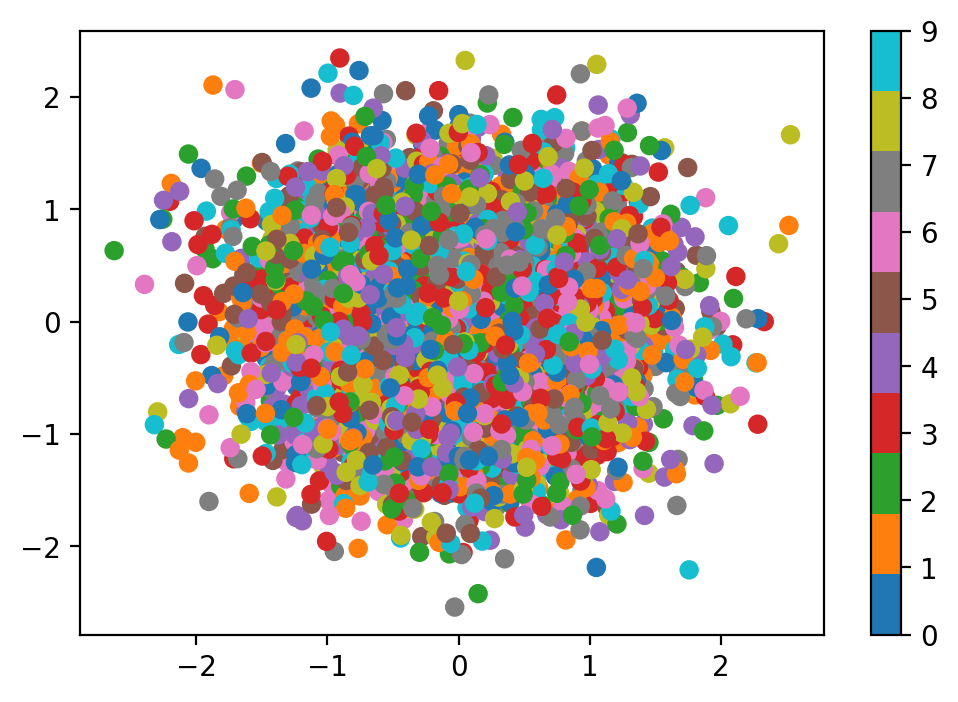

In [154]:
plot_latent(vae, train_loader)

Пространство сжалось, стало компактнее по сравнению с реализацией VAE на линейных слоях, но при классы разбросаны  

In [139]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [165]:
x, y = next(iter(test_loader)) # hack to grab a batch
x_1 = x[y == 1][0].view(1, 1, 28, 28).to(device) # find a 1
x_2 = x[y == 7][0].view(1, 1, 28, 28).to(device) # find a 0

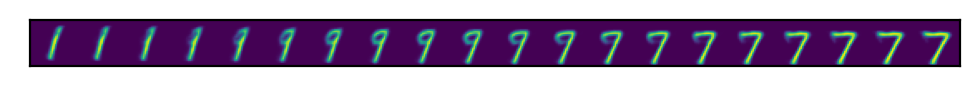

In [166]:
interpolate(vae, x_1, x_2, n=20)